Jakiś czas temu pokazywałem jak w prosty sposób narysować mapę w R. Dzisiaj powtórzymy zadanie dla Pythona.

Skorzystamy z danych GUS na temat bezrobocia oraz liczby ludności (pomijając dokładność *złożenia* danych - interesuje nas rysowanie map, a nie analiza bezrobocia) oraz map z Głównego Urzędu Geodezji i Kartografii.

> Jeśli potrzebujesz podobnych informacji jak zrobić to wszysto w R sprawdź na początek wszystko co jest w ramach tagu [mapa](https://blog.prokulski.science/index.php/tag/mapa/)

### Skąd pobrać dane?

* **Dane o liczbie ludności**: [Ludność / Stan ludności / Ludność wg grup wieku i płci](https://bdl.stat.gov.pl/BDL/metadane/cechy/2137) w tzw. **BDLu** (czyli Banku Danych Lokalnych GUS) - bierzemy dane z 2018 roku (najnowsze pełne jakie są); Wiek = ogółem, Płeć = ogółem; wszystkie jednostki terytorialne. W wyniku klikania dostaniemy się do tabeli, którą ściągamy lokalnie poprzez **Export / CSV - tablica wielowymiarowa**.
* Dokładnie tak samo pozyskujemy **dane o liczbie bezrobotnych**: [Rynek pracy / Bezrobocie rejestrowane / Bezrobotni zarejestrowani wg płci w gminach](https://bdl.stat.gov.pl/BDL/metadane/cechy/1944) (znowu: ogółem, 2019 rok, wszystkie jednostki; pobieramy plik CSV dokładnie tak samo jak wyżej).
* **Dane mapowe** bierzemy z [GUGiK](http://www.gugik.gov.pl/pzgik/dane-bez-oplat/dane-z-panstwowego-rejestru-granic-i-powierzchni-jednostek-podzialow-terytorialnych-kraju-prg) - interesuje nas archiwum [PRG – jednostki administracyjne](ftp://91.223.135.109/prg/jednostki_administracyjne.zip) (uwaga - to ma 375 MB!). To archiwum rozapkowujemy i (coś co ja robię, żeby później nie było problemów) zmieniamy nazwy plików tak, aby pozbyć się polskich znaków i wszystkie litery w nazwie były małe.


### Przygotowanie danych z GUS

Ale zanim - porzebne nam będzie kilka pakietów Pythona do dalszej pracy:`

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
import folium

### Mapy w Shapefile

Pobrane z BDLa pliki mają swoje nazwy, które są zależne od daty wygenerowania danych. Zapiszmy więc je w zmiennych, aby ewentualnie zmieniać je tylko w jednym miejscu:

In [2]:
dane_gus_ludnosc_file = 'LUDN_2137_CTAB_20200228102408.csv'
dane_gus_bezrobocie_file = 'RYNE_1944_CTAB_20200228102648.csv'

Teraz możemy wczytać i przejrzeć z grubsza te dane. Zaczniemy od ludności:

In [3]:
ludnosc_gus = pd.read_csv(dane_gus_ludnosc_file, delimiter=';')
ludnosc_gus.head()

,Kod,Nazwa,ogółem;ogółem;2018;[osoba],Unnamed: 3
0,0,POLSKA,38411148,NaN
1,200000,DOLNOŚLĄSKIE,2901225,NaN
2,201000,Powiat bolesławiecki,90200,NaN
3,201011,Bolesławiec (1),38935,NaN
4,201022,Bolesławiec (2),14626,NaN


Jest tutaj lekki bałagan. Ale co jest czym?

* `Kod` - kolumna odowiadająca za kod [TERYT](https://pl.wikipedia.org/wiki/TERYT) gminy, a tak na prawdę jest to [TERC](https://pl.wikipedia.org/wiki/TERC). Jeśli chociaż raz analizowałeś (lub -aś) dane geograficzne dotyczące Polski to na pewno to znasz. Będzie to klucz łączący dane z obszarami na mapie.
* `Nazwa` - nazwa regionu. W zależności od regionu będzie to nazwa gminy, powiatu albo województwa. Lub też *POLSKA* dla całego kraju. Do niczego nam to w sumie tutaj nie jest potrzebne.
* `ogółem;ogółem;2018;[osoba]` - to jest interesująca nas liczba, ale nazwa kolumny jest jakimś babolem. Tak to przychodzi z GUSu :(
* ostatnia kolumna to śmieć (bo linie kończa się średnikiem nie wiedzieć czemu)

Zostawimy więc interesujące nas kolumny i zmienimy ich nazwy:

In [4]:
ludnosc_gus = ludnosc_gus.iloc[:, 0:3]
ludnosc_gus.columns = ['TERYT', 'Nazwa', 'Ludnosc']
ludnosc_gus.head()

,TERYT,Nazwa,Ludnosc
0,0,POLSKA,38411148
1,200000,DOLNOŚLĄSKIE,2901225
2,201000,Powiat bolesławiecki,90200
3,201011,Bolesławiec (1),38935
4,201022,Bolesławiec (2),14626


Mamy to czego chcieliśmy. Teraz ta sama operacja dla danych o bezrobociu:

In [5]:
bezrobocie_gus = pd.read_csv(dane_gus_bezrobocie_file, delimiter=';')
bezrobocie_gus.head()

,Kod,Nazwa,ogółem;2019;[osoba],Unnamed: 3
0,0,POLSKA,866374,NaN
1,200000,DOLNOŚLĄSKIE,56022,NaN
2,201000,Powiat bolesławiecki,1293,NaN
3,201011,Bolesławiec (1),516,NaN
4,201022,Bolesławiec (2),198,NaN


Pierwsze dwie kolumny znaczą to samo co w poprzednim zbiorze, trzecia to liczba zarejestrowanych bezrobotnych. Tym razem pozbędziemy się od razu kolumny z nazwą - nie będzie nam do niczego potrzebna, a am TERYT wystarczy jako klucz łączący.

In [6]:
bezrobocie_gus = bezrobocie_gus.iloc[:, [0, 2]]
bezrobocie_gus.columns = ['TERYT', 'Bezrobotni']
bezrobocie_gus.head()

,TERYT,Bezrobotni
0,0,866374
1,200000,56022
2,201000,1293
3,201011,516
4,201022,198


Kolejny krok to złączenie danych - w jednej tabeli będziemy trzymać informacje o ludności i liczbie bezrobotnych i na tej podstawie łatwo policzymy stopę bezrobocia.

Tutaj **uwaga** - wynik nie będzie poprawny metodologicznie. Dane o ludności mamy z połowy 2019 roku, a o bezrobociu - z końca lutego 2020. Liczba ludności mogła się zmienić przez te półtora roku. Druga rzecz - w liczbę ludności wchodzą też zosoby, które nie są w *wieku produkcyjnym*, więc nie powinny być liczone. Ale ten *drobny niuans* pomijamy, bo naszym celem jest nauczyć się rysować mapę, a nie liczyć stopę bezrobocia. Oczywiście można w GUSie znaleźć dane o liczbie osób w wieku produkcyjnym - niestety nie będą one tak samo aktualne jak te związane z liczbą bezrobotnych. Ale przed nami narodowy spi powszechny, więc niedługo nowe dane o Polakach.

In [7]:
# łączymy dane ze sobą - tylko te kody TERYT, które istnieją w obu tabelach
dane_gus = pd.merge(ludnosc_gus, bezrobocie_gus, how='inner', on='TERYT')

# liczymy stopę bezrobocia w każdym z TERYTów:
dane_gus['Stopa_bezrobocia'] = 100* dane_gus['Bezrobotni'] / dane_gus['Ludnosc']

# 10 przykładowych wierszy:
dane_gus.sample(10)

,TERYT,Nazwa,Ludnosc,Bezrobotni,Stopa_bezrobocia
3152,2607045,Ćmielów - obszar wiejski (5),4337,191,4.403966
168,216000,Powiat polkowicki,62982,1651,2.621384
4097,3218000,Powiat łobeski,37104,2032,5.476498
2580,2012012,Bakałarzewo (2),3097,41,1.323862
3098,2604044,Chmielnik - miasto (4),3703,115,3.105590
2824,2402082,Porąbka (2),15589,157,1.007120
328,402042,Brzozie (2),3793,88,2.320063
2130,1609084,Ozimek - miasto (4),8725,150,1.719198
1420,1210164,Stary Sącz - miasto (4),9048,247,2.729885
677,608132,Uścimów (2),3194,134,4.195366


Wydawać sie może, że to wszystko. Ale... poczekajmy ;)

#### Wczytanie mapy

Czas na wczytanie naszych danych geograficznych. Użyjemy dwóch map: podziału na gminy i podziału na województwa. Bo też narysujemy dwie mapki - dwoma sposobami! Ha, jaka niespodzianka :)

Zaczynamy od wczytania danych z Shapefile (taki format danych - to pobraliśmy z GUGiK):

In [8]:
# mapa z województwami:
mapa_woj = gpd.read_file('../map_data/wojewodztwa.shp')
mapa_woj.dtypes

JPT_SJR_KO      object
JPT_KOD_JE      object
JPT_NAZWA_      object
JPT_ORGAN_      object
JPT_JOR_ID       int64
WERSJA_OD       object
WERSJA_DO       object
WAZNY_OD        object
WAZNY_DO        object
JPT_KOD__1      object
JPT_NAZWA1      object
JPT_ORGAN1      object
JPT_WAZNA_      object
ID_BUFORA_     float64
ID_BUFORA1     float64
ID_TECHNIC       int64
IIP_PRZEST      object
IIP_IDENTY      object
IIP_WERSJA      object
JPT_KJ_IIP      object
JPT_KJ_I_1      object
JPT_KJ_I_2      object
JPT_OPIS        object
JPT_SPS_KO      object
ID_BUFOR_1       int64
JPT_ID           int64
JPT_KJ_I_3      object
Shape_Leng     float64
Shape_Area     float64
geometry      geometry
dtype: object

In [9]:
# mapa z gminami:
mapa_gmn = gpd.read_file('../map_data/gminy.shp')
mapa_gmn.dtypes

JPT_SJR_KO      object
JPT_KOD_JE      object
JPT_NAZWA_      object
JPT_ORGAN_      object
JPT_JOR_ID       int64
WERSJA_OD       object
WERSJA_DO       object
WAZNY_OD        object
WAZNY_DO        object
JPT_KOD__1      object
JPT_NAZWA1      object
JPT_ORGAN1      object
JPT_WAZNA_      object
ID_BUFORA_     float64
ID_BUFORA1     float64
ID_TECHNIC       int64
IIP_PRZEST      object
IIP_IDENTY      object
IIP_WERSJA      object
JPT_KJ_IIP      object
JPT_KJ_I_1      object
JPT_KJ_I_2      object
JPT_OPIS        object
JPT_SPS_KO      object
ID_BUFOR_1       int64
JPT_ID           int64
JPT_KJ_I_3      object
Shape_Leng     float64
Shape_Area     float64
geometry      geometry
dtype: object

Co my tutaj mamy? Dużo różnych koklumn, ale interesują nas tak naprawdę tylko dwie: `JPT_KOD_JE` oraz `geometry`. Pierwsza to po prostu kod TERYT, a druga opisuje kształt obszaru. Zostawmy więc sobie tylko te dwie kolumny i zobaczmy jak wyglądają dane:

In [10]:
mapa_woj = mapa_woj[['JPT_KOD_JE', "geometry"]]

mapa_gmn = mapa_gmn[['JPT_KOD_JE', "geometry"]]
mapa_gmn.head()

,JPT_KOD_JE,geometry
0,1203022,"POLYGON ((19.43443 50.02313, 19.43409 50.02316..."
1,1204042,"POLYGON ((20.92531 50.24308, 20.92531 50.24308..."
2,2010082,"POLYGON ((22.60796 52.51705, 22.60798 52.51711..."
3,0222033,"POLYGON ((16.49835 51.22612, 16.49692 51.22615..."
4,0223022,"POLYGON ((17.24961 51.10001, 17.24918 51.10003..."


Proszę zwrócić uwagę, że kody TERYT (dla gmin) mają *wiodące zero* i zawsze jest to 7 cyfr. W danych z GUS pandas potraktował tę kolumnę jako liczbę i obciął nam wiodące zera. Można o to zadbać na poziomie wczytywania danych (odpowiednia wartość parametru `dtype` dla `pd.read_csv()`) ale trzeba znać listę kolumn.

Zamiast tego zrobimy korektę w naszych danych przy okazji wyłuskując kod TERYT województwa z kodu gminy:

In [11]:
# kod ma być stringiem o stałejdługości (dodanie wiodących zer)
dane_gus['TERYT_gmn'] = dane_gus.TERYT.apply(lambda x: '0'+str(x) if len(str(x)) < 7 else str(x))

# TERYT województwa
dane_gus['TERYT_woj'] = dane_gus.TERYT_gmn.apply(lambda s: s[:2])

dane_gus.head()

,TERYT,Nazwa,Ludnosc,Bezrobotni,Stopa_bezrobocia,TERYT_gmn,TERYT_woj
0,0,POLSKA,38411148,866374,2.255527,00,00
1,200000,DOLNOŚLĄSKIE,2901225,56022,1.930977,0200000,02
2,201000,Powiat bolesławiecki,90200,1293,1.433481,0201000,02
3,201011,Bolesławiec (1),38935,516,1.325286,0201011,02
4,201022,Bolesławiec (2),14626,198,1.353754,0201022,02


Jeszcze przydałoby się usunąć agregaty do poziomu powiatów oraz informację dla całego kraju. Rozdzielimy też tabelę na dane o gminach i województwach.

Powiat charakteryzuje się tym, że ostatnie 3 cyfry w kodzie TERYT to zera, zaś w przypadku województwa - to ostatnie 5 cyfr jest zerami. Zadanie więc dość proste:`

In [12]:
# usuwamy wiersz dla całego kraju:
dane_gus = dane_gus[dane_gus['TERYT'] != '0']

# wybieramy same województwa - 00000 na końcu
dane_gus_woj = dane_gus[dane_gus.TERYT_gmn.str[2:7] == '00000']
dane_gus_woj

/usr/local/lib/python3.6/dist-packages/pandas/core/ops/array_ops.py:253: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  res_values = method(rvalues)


,TERYT,Nazwa,Ludnosc,Bezrobotni,Stopa_bezrobocia,TERYT_gmn,TERYT_woj
1,200000,DOLNOŚLĄSKIE,2901225,56022,1.930977,0200000,02
313,400000,KUJAWSKO-POMORSKIE,2077775,64060,3.083106,0400000,04
551,600000,LUBELSKIE,2117619,69379,3.276274,0600000,06
845,800000,LUBUSKIE,1014548,18498,1.823275,0800000,08
1010,1000000,ŁÓDZKIE,2466322,58722,2.380954,1000000,10
1264,1200000,MAŁOPOLSKIE,3400577,62610,1.841158,1200000,12
1562,1400000,MAZOWIECKIE,5403412,123208,2.280189,1400000,14
2022,1600000,OPOLSKIE,986506,20948,2.123454,1600000,16
2172,1800000,PODKARPACKIE,2129015,75455,3.544127,1800000,18
2428,2000000,PODLASKIE,1181533,33277,2.816426,2000000,20


In [13]:
# wybieramy same gminy - 00000 na końcu
dane_gus_gmn = dane_gus[dane_gus.TERYT_gmn.str[4:7] != '000']
dane_gus_gmn

,TERYT,Nazwa,Ludnosc,Bezrobotni,Stopa_bezrobocia,TERYT_gmn,TERYT_woj
0,0,POLSKA,38411148,866374,2.255527,00,00
3,201011,Bolesławiec (1),38935,516,1.325286,0201011,02
4,201022,Bolesławiec (2),14626,198,1.353754,0201022,02
5,201032,Gromadka (2),5367,76,1.416061,0201032,02
6,201043,Nowogrodziec (3),15258,234,1.533622,0201043,02
...,...,...,...,...,...,...,...
4109,3218054,Węgorzyno - miasto (4),2831,90,3.179089,3218054,32
4110,3218055,Węgorzyno - obszar wiejski (5),4168,262,6.285988,3218055,32
4112,3261011,Koszalin (1),107321,2202,2.051789,3261011,32
4114,3262011,Szczecin (1),402465,4274,1.061956,3262011,32


### Narysowanie mapy - matplotlib

To teraz najciekwsze - rysujemy wreszcie mapę.

Piresze podejście to użycie standardowego `matplotlib`. Aby tego dokońać znowu musimy połączyć dane do jednego *data frame'a*. Zajmimy się województwami.

In [14]:
# łączyy tabelę opisującą kształt województw z danymi o bezrobosiu w województwach
dane_mapa_woj = pd.merge(mapa_woj, dane_gus_woj, how='left', left_on='JPT_KOD_JE', right_on='TERYT_woj')
dane_mapa_woj

,JPT_KOD_JE,geometry,TERYT,Nazwa,Ludnosc,Bezrobotni,Stopa_bezrobocia,TERYT_gmn,TERYT_woj
0,24,"MULTIPOLYGON (((18.91685 51.09608, 18.91677 51...",2400000,ŚLĄSKIE,4533565,66521,1.467300,2400000,24
1,16,"POLYGON ((17.81203 51.18669, 17.81209 51.18670...",1600000,OPOLSKIE,986506,20948,2.123454,1600000,16
2,30,"POLYGON ((16.71447 53.29913, 16.71447 53.29920...",3000000,WIELKOPOLSKIE,3493969,46313,1.325513,3000000,30
3,32,"POLYGON ((14.22608 53.92774, 14.22633 53.92864...",3200000,ZACHODNIOPOMORSKIE,1701030,41771,2.455630,3200000,32
4,26,"POLYGON ((19.70430 50.75239, 19.70443 50.75248...",2600000,ŚWIĘTOKRZYSKIE,1241546,42042,3.386262,2600000,26
5,04,"POLYGON ((17.65670 53.57115, 17.65672 53.57115...",400000,KUJAWSKO-POMORSKIE,2077775,64060,3.083106,0400000,04
6,20,"POLYGON ((21.98108 52.97859, 21.98078 52.97861...",2000000,PODLASKIE,1181533,33277,2.816426,2000000,20
7,02,"POLYGON ((15.10534 51.42730, 15.10540 51.42732...",200000,DOLNOŚLĄSKIE,2901225,56022,1.930977,0200000,02
8,18,"POLYGON ((22.03538 50.80675, 22.03550 50.80681...",1800000,PODKARPACKIE,2129015,75455,3.544127,1800000,18
9,12,"POLYGON ((19.97230 50.51625, 19.97227 50.51633...",1200000,MAŁOPOLSKIE,3400577,62610,1.841158,1200000,12


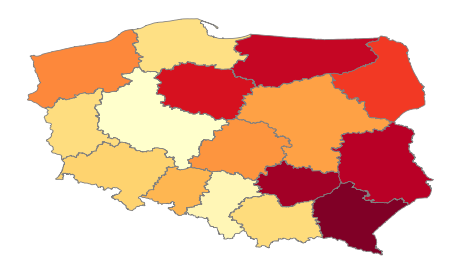

In [15]:
## rysujemy mapkę:
# wielkość naszego obrazka
fig, ax = plt.subplots(1, figsize = (8,8))

# rysowanie mapy
dane_mapa_woj.plot(column='Stopa_bezrobocia', ax=ax, cmap='YlOrRd', linewidth=0.8, edgecolor='gray')

# usuwamy osie
ax.axis('off')

# pokazujemy obrazek
plt.savefig('bezrobocie_woj_1.png')
plt.show()

![](bezrobocie_woj_1.png)

Wyszło jakoś, chociaż kształt Polski jest spłaszczony. Odpowiada za to kodowanie współrzędnych w plikach z GUGiK. Dane o współrzęrznych trzeba nieco przekonwertować (było trochę googlania za wartością EPSG, macie gotowy efekt poniżej) Zróbmy to i powtórzmy operację rysowania:

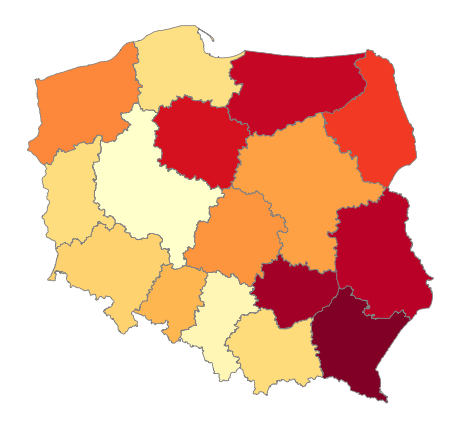

In [16]:
dane_mapa_woj = dane_mapa_woj.to_crs(epsg=2180)

fig, ax = plt.subplots(1, figsize = (8,8))
dane_mapa_woj.plot(column='Stopa_bezrobocia', ax=ax, cmap='YlOrRd', linewidth=0.8, edgecolor='gray')
ax.axis('off')
plt.savefig('bezrobocie_woj_2.png')
plt.show()

![](bezrobocie_woj_2.png)

Od razu lepiej!

### Narysowanie mapy - Folium

A gdyby tak zrobić mapę interaktywną? Taką, którą można przesuwać i skalować? Do tego użyjemy pakietu `Folium` oraz danych na poziomie gmin.

Jednak `Folium` potrzebuje danych o obszarach w formacie GeoJSON, zatem musimy je odpowiednio przygotować.

#### Uproszczenie kształtu

W pierwszej kolejności uprościmy (*zaokrąglimy*) dane mapowe, aby nie zajmowały zbyt wiele miejsca. Będzie to miało wpływ na niedokładność kształtów gmin.

In [17]:
# uproszczenie geometrii
mapa_gmn.geometry = mapa_gmn.geometry.simplify(0.005) # mniejsza wartosc = bardziej dokładnie

# dane do GeOJSON na potrzeby Folium
gmn_geoPath = mapa_gmn.to_json()

Teraz już możemy rysować naszą mapkę:

In [19]:
# 52,19 to w przybliżeniu środek mapy w postaci lat,long
mapa = folium.Map([52, 19], zoom_start=6)

folium.Choropleth(geo_data=gmn_geoPath, # GeJSON z danymi geograficznymi obszarów
                  data=dane_gus_gmn, # data frame z danymi do pokazania
                  columns=['TERYT_gmn', 'Stopa_bezrobocia'], # kolumna z kluczem, kolumna z wartościami
                  key_on='feature.properties.JPT_KOD_JE', # gdzie jests klucz w GeoJSON?
                  fill_color='YlOrRd', 
                  fill_opacity=0.7,
                  line_opacity=0.2,
                  legend_name="Stopa bezrobocia w gminie").add_to(mapa)

# zapisanie utworzonej mapy do pliku HTML
mapa.save(outfile = 'bezrobocie_gminy.html')

Przy dużym zoomie widać, że granice gmin się ze sobą nie stykają - to wynik uproszczenia geometrii. Bez tego kroku powinno wszystko do siebie pasować.

> Jeśli potrzebujesz podobnych informacji jak zrobić to wszysto w R sprawdź na początek tekst [Mapy, mapy raz jeszcze](/index.php/2017/12/22/mapy-w-r-rgeos/) oraz wszystko co jest w ramach tagu [mapa](/index.php/tag/mapa/)

Ale widać też coś innego - niektóre z gmin są szare. Dlaczego? Ponieważ brakuje dla nich danych. To z kolei wynika z rozbieżności pomiędzy kodami TERYT w danych geograficznych z GUGiK oraz danych o bezrobociu z GUS. Najszęściej chodzi o to, że w GUS są bardziej aktualne dane uwzględniające na przykład zmianę charakteru gminy (ostatnia cyfra w kodzie TERYT) z wiejskiej na miejską lub odwrotnie. Podobny problem można spotkać w przypadku Warszwy - dane mapowe traktują ją jako całość, a dane w GUS często odnoszą się do każdej z dzielnic (i tym samym gmin) oddzielnie.

Jak z tym sobie poradzić? Najprościej byłoby nie przejmować się ostatnią cyfrą w kodzie TERYT. Wówczas trzeba wykonać dwa ruchy *wyprzedzające*:

* obciąć kod TERYT do 6 cyfr i zagregować dane do tak powstałych kodów - dla danych np. z GUS. To dość proste przekształcenie w Pandas
* zrobić dokładnie to samo dla danych mapowych - tutaj agregacja jest nieco trudniejsza (obliczeniowo), ale [dokumentacja](https://geopandas.org/aggregation_with_dissolve.html) wyjaśnia co i jak

---

> Mam nadzieję, że dzisiaj zdobyta wiedza na coś Ci się przyda. Wiedza za darmo, ale zawsze możesz [postawić witrualną kawę](https://www.paypal.me/prokulski/10pln).

Jeśli prowadzisz biznes i zadajesz sobie jakieś pytania to może **[mogę Ci pomóc](/index.php/oferta/)**? Trochę już w swoim życiu danych przerzuciłem w różne strony, trochę pytań zadałem. I projektów zrobiłem.


Jeśli chcesz być na bieżąco z tym co dzieje się w analizie danych, machine learning i AI polub **[Dane i Analizy](http://fb.com/DaneAnalizy)** na Facebooku oraz **[rstatspl](https://twitter.com/rstatspl)** na Twitterze. Znajdziesz tam potężną dawkę wiedzy.

Dość prężnie działa też **[konto na Instagramie](https://www.instagram.com/data_science_bitch/)** gdzie znajdziecie różne wykresiki :)